In [ ]:
# Get data from kaggle
# Before executing, please download kaggle.json from your kaggle account
# Refer : https://github.com/Kaggle/kaggle-api
# Dataset Link : https://www.kaggle.com/c/ifood-2019-fgvc6
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download ifood-2019-fgvc6


In [ ]:
# The dataset contains images of 251 food categories.
# Train data from train_set.zip (80% train, 20% validation)
# test data from val_set.zip
# labels are available only for train_set.zip and val_set.zip
!unzip train_set.zip
#!unzip test_set.zip
!unzip val_set.zip
!unzip train_labels.csv.zip

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import PIL
import tensorflow as tf
import csv

from tensorflow import keras
from tensorflow.keras import layers, losses, Model
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint

In [3]:
# create class dict
class_dict = {}
with open('class_list.txt', 'r') as file:
  tmp = file.readlines()
for i in tmp:
  class_id, class_name = i.split()
  class_dict[int(class_id)] = class_name[:-1]

print("total number of classes = ", len(class_dict))

total number of classes =  251


In [7]:
# Convert the data folder with images to the format 
# data_folder/class_name_folder/image
label_fnames = ["train_labels.csv", "val_labels.csv"]
data_paths = ["train_set/", "val_set/"]

for label_fname, data_path in zip(label_fnames, data_paths):
  with open(label_fname) as file:
    label_lines = file.readlines()

  for line in label_lines[1:] :
    food_fname, class_id = line.split(",")
    food_name = class_dict[int(class_id[:-1])]

    dest_folder = data_path+food_name+"/"
    if not os.path.exists(dest_folder):
      os.makedirs(dest_folder)

    shutil.move(data_path+food_fname, dest_folder+food_fname)


In [12]:
#constants
IMG_SIZE = (224, 224)
CHANNELS = 3
IMG_SHAPE = IMG_SIZE+(CHANNELS,)
BATCH_SIZE = 32
DATA_DIR = "./train_set_small"

In [13]:
# create a smaller train and valid set of 5 classes
! rm -rf val_set_small
!rm -rf train_set_small
!mkdir train_set_small
!mkdir val_set_small
! cp -r  train_set/biryan train_set/apple_pi train_set/eggs_benedic train_set/cupcak train_set/chicken_curr  train_set_small/
! cp -r  val_set/biryan val_set/apple_pi val_set/eggs_benedic val_set/cupcak val_set/chicken_curr  val_set_small/

In [14]:
# Print the classes and total images per each class
print("train Set")
base_path = "train_set_small/"
for dir in os.listdir(base_path):
  print(dir, ":",len([i for i in os.listdir(base_path+dir)]))

print("\nval set")
base_path = "val_set_small/"
for dir in os.listdir(base_path):
  print(dir, ":",len([i for i in os.listdir(base_path+dir)]))

train Set
cupcak : 451
eggs_benedic : 521
apple_pi : 549
chicken_curr : 471
biryan : 518

val set
cupcak : 53
eggs_benedic : 65
apple_pi : 41
chicken_curr : 41
biryan : 64


In [15]:
# A dataset is imbalanced when the image nubers per class varies
# This might affect the model performance. Easy method to balance dataset by 
# deleting extra images.
# this is only needed for train set.
base_path = "train_set_small/"
total=0
max_count = 450
for dir in os.listdir(base_path):
  count = 1
  for i in os.listdir(base_path+dir):
    if count > max_count:
      os.remove(base_path+dir+"/"+i)
    else:
      count += 1

  print(dir, ":",len([i for i in os.listdir(base_path+dir)]))
  total += len([i for i in os.listdir(base_path+dir)])
print("Total : ",total)


cupcak : 450
eggs_benedic : 450
apple_pi : 450
chicken_curr : 450
biryan : 450
Total :  2250


In [16]:
#Load train data
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2250 files belonging to 5 classes.
Using 1800 files for training.


In [17]:
#Load Validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2250 files belonging to 5 classes.
Using 450 files for validation.


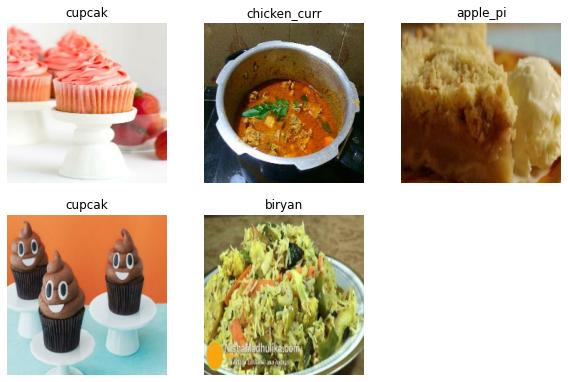

In [18]:
# Visualize sample data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [19]:
class_names = train_ds.class_names
print(class_names)

['apple_pi', 'biryan', 'chicken_curr', 'cupcak', 'eggs_benedic']


In [ ]:
#Configure dataset for performance
'''
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
'''

In [23]:
# Preparing base model
base_model = tf.keras.applications.VGG19(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')
base_model.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


In [21]:
# Base model specific pre-processing
preprocess = tf.keras.applications.vgg19.preprocess_input

In [22]:
# Data augmentation
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.2),
                                      layers.RandomZoom(0.1)],)


In [20]:
num_classes = len(class_names)
# New layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = layers.Dense(512, activation='relu')
drop_out_layer = layers.Dropout(0.2)
prediction_layer = layers.Dense(num_classes)

In [24]:
# assemble the model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dense_layer(x)
x = drop_out_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
# Compile the model
base_learn_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learn_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
checkpoint = ModelCheckpoint("drive/MyDrive/food-data/best_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [ ]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/30
57/57 [==============================] - ETA: 0s - loss: 2.5432 - accuracy: 0.4444
Epoch 00001: val_accuracy improved from -inf to 0.73111, saving model to drive/MyDrive/food-data/best_model.hdf5
57/57 [==============================] - 31s 267ms/step - loss: 2.5432 - accuracy: 0.4444 - val_loss: 0.9439 - val_accuracy: 0.7311
Epoch 2/30
57/57 [==============================] - ETA: 0s - loss: 1.1291 - accuracy: 0.6867
Epoch 00002: val_accuracy improved from 0.73111 to 0.80667, saving model to drive/MyDrive/food-data/best_model.hdf5
57/57 [==============================] - 12s 212ms/step - loss: 1.1291 - accuracy: 0.6867 - val_loss: 0.6488 - val_accuracy: 0.8067
Epoch 3/30
57/57 [==============================] - ETA: 0s - loss: 0.8738 - accuracy: 0.7633
Epoch 00003: val_accuracy improved from 0.80667 to 0.84222, saving model to drive/MyDrive/food-data/best_model.hdf5
57/57 [==============================] - 12s 210ms/step - loss: 0.8738 - accuracy: 0.7633 - val_loss: 0.5589 

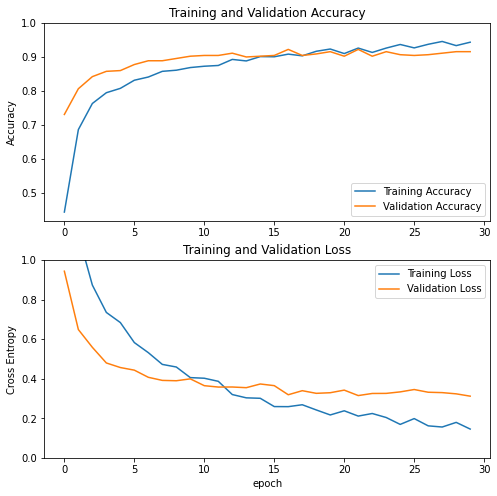

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
#model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
history_tune = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/10
57/57 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9267
Epoch 00001: val_accuracy did not improve from 0.92222
57/57 [==============================] - 37s 533ms/step - loss: 0.2077 - accuracy: 0.9267 - val_loss: 0.3860 - val_accuracy: 0.9133
Epoch 2/10
57/57 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9461
Epoch 00002: val_accuracy did not improve from 0.92222
57/57 [==============================] - 30s 515ms/step - loss: 0.1413 - accuracy: 0.9461 - val_loss: 0.3376 - val_accuracy: 0.9111
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9567
Epoch 00003: val_accuracy did not improve from 0.92222
57/57 [==============================] - 30s 522ms/step - loss: 0.1187 - accuracy: 0.9567 - val_loss: 0.4881 - val_accuracy: 0.8956
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9500
Epoch 00004: val_accuracy did not improve from 0.92222
57/57 [=

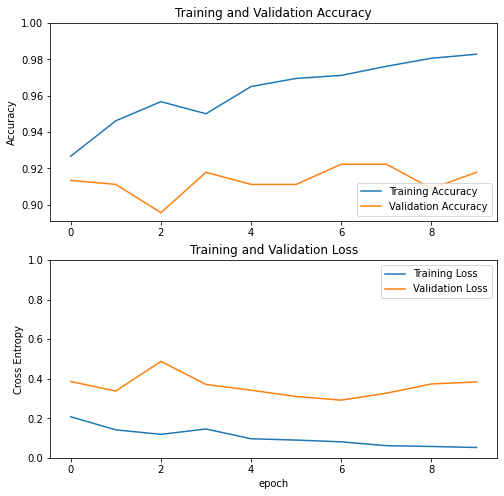

In [ ]:
acc = history_tune.history['accuracy']
val_acc = history_tune.history['val_accuracy']

loss = history_tune.history['loss']
val_loss = history_tune.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [8]:
#evaluate the best model using test data
path_to_best_weight = "/content/drive/MyDrive/food-data/best_model_vgg19_2_90val.hdf5"
model.load_weights(path_to_best_weight)

In [ ]:
TEST_DATA_DIR = "./val_set_small"
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DATA_DIR,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 264 files belonging to 5 classes.


In [ ]:
#test accuracy
model.evaluate(test_ds)

9/9 [==============================] - 2s 136ms/step - loss: 0.2683 - accuracy: 0.9129


[0.26831260323524475, 0.9128788113594055]

In [36]:
class_names = ['apple_pi', 'biryan', 'chicken_curr', 'cupcak', 'eggs_benedic']
# Get the image
img = tf.keras.utils.load_img(
    "/content/apple_pi.jpeg"
)
img = img.resize(IMG_SIZE)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
predictions = model.predict(img_array)

#Compute probability
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to apple_pi with a 100.00 percent confidence.
